In [1]:
import datetime
import os
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import webbpsf
import galsim
from galsim import roman
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, psf

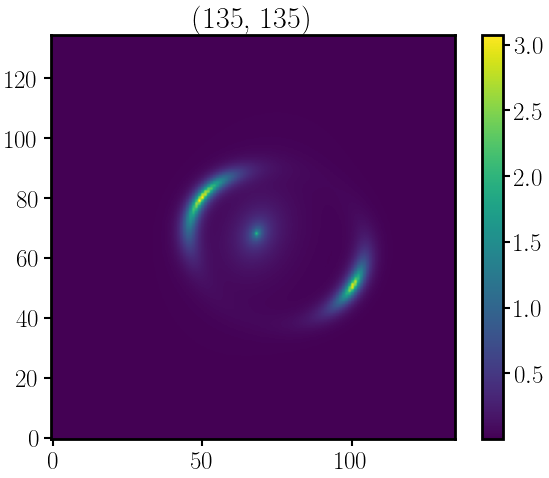

In [2]:
# pprint(roman.getBandpasses())
band = 'F129'
filter_name = 'J129'
exposure_time = 146
oversample_factor = 3

lens = SampleStrongLens()
# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'pyhalo', 'cdm_subhalos_tuple')))
# model = lens.get_array(num_pix=91 * oversample_factor, side=10.01, band=band)
model = lens.get_array(num_pix=45 * oversample_factor, side=4.95, band=band)

model_side, _ = model.shape
plot.plot(model, colorbar=True, title=model.shape)

In [3]:
start = time.time()

# get flux
total_flux_cps = lens.get_total_flux_cps(band)
print(total_flux_cps)

375.2308550377718


In [4]:
roman_filters = roman.getBandpasses(AB_zeropoint=True)
pprint(roman_filters)
bandpass = roman_filters[filter_name]

detector = 1
detector_position = galsim.PositionD(2048, 2048)

ra_targ = galsim.Angle.from_hms('16:01:41.01257')
dec_targ = galsim.Angle.from_dms('66:48:10.1312')
targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)

date = datetime.datetime(2025, 5, 16)

wcs_dict = roman.getWCS(world_pos=targ_pos, SCAs=detector, date=date)
wcs = wcs_dict[detector]

{'F184': galsim.Bandpass(galsim.LookupTable(x=array([1605.0, 1620.0, 1630.0, 1635.0, 1640.0, 1645.0, 1650.0, 1655.0, 1660.0, 1665.0, 1670.0, 1675.0, 1680.0, 1685.0, 1690.0, 1695.0, 1700.0, 1705.0, 1710.0, 1715.0, 1720.0, 1725.0, 1730.0, 1735.0, 1740.0, 1745.0, 1750.0, 1755.0, 1765.0, 1775.0, 1785.0, 1795.0, 1805.0, 1810.0, 1835.0, 1840.0, 1845.0, 1850.0, 1855.0, 1860.0, 1865.0, 1895.0, 1900.0, 1905.0, 1910.0, 1925.0, 1935.0, 1940.0, 1945.0, 1950.0, 1955.0, 1960.0, 1965.0, 1970.0, 1975.0, 1980.0, 1985.0, 1990.0, 1995.0, 2005.0, 2009.9999999999998, 2015.0000000000002, 2020.0, 2025.0, 2029.9999999999998, 2035.0000000000002, 2040.0, 2045.0, 2050.0, 2055.0, 2060.0, 2065.0, 2075.0, 2090.0]), f=array([0.0, 0.0004, 0.0023, 0.0047, 0.0092, 0.0169, 0.0295, 0.0486, 0.0759, 0.11240000000000001, 0.1582, 0.2121, 0.2716, 0.3334, 0.3937, 0.44909999999999994, 0.497, 0.5369, 0.5682, 0.5917, 0.6087, 0.6208, 0.6294, 0.6356, 0.6401, 0.6435, 0.6458, 0.6469, 0.6472, 0.6457, 0.6426, 0.6383, 0.6329, 0.6298, 0.

In [5]:
# get interpolated image
interp = InterpolatedImage(Image(model), scale=0.11 / oversample_factor, flux=total_flux_cps * exposure_time)

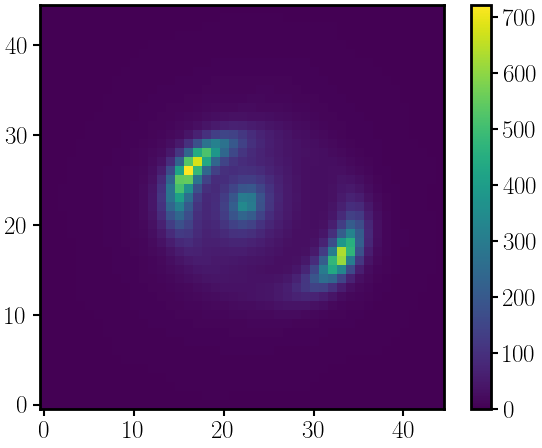

In [6]:
# somewhere in here, retrieve an off-axis PSF with WebbPSF, import as a galsim.InterpolatedImage, then convolve using a GalSim method
galsim_psf = roman.getPSF(detector, SCA_pos=detector_position, bandpass=None, wavelength=bandpass, pupil_bin=1)  # test with different pupil bin, 1 (4096x4096) is best but slowest, don't go any larger than 8 (512x512)

# https://galsim-developers.github.io/GalSim/_build/html/composite.html#galsim.Convolve
galsim_convolved = galsim.Convolve(interp, galsim_psf)

# draw interpolated image
galsim_drawn = galsim.ImageF(45, 45, scale=0.11)
galsim_drawn.setOrigin(0, 0)
galsim_final = galsim_convolved.drawImage(galsim_drawn)

# integer number of photons are being detected, so quantize
galsim_final.quantize()

plot.plot(galsim_final.array, colorbar=True)

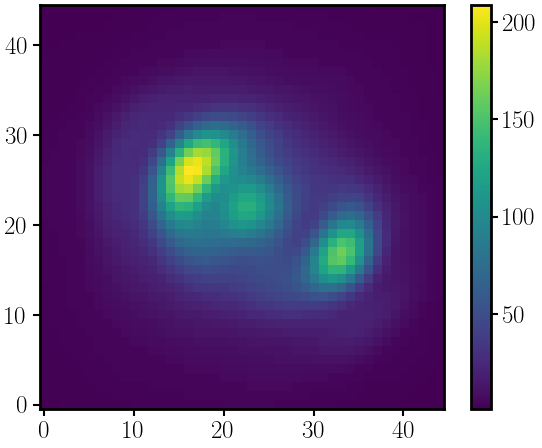

In [9]:
# get interpolated image
interp = InterpolatedImage(Image(model), scale=0.11 / oversample_factor, flux=total_flux_cps * exposure_time)

# draw interpolated image
im = galsim.ImageF(45, 45, scale=0.11)
im.setOrigin(0, 0)
drawn = interp.drawImage(im)

wfi = webbpsf.roman.WFI()
wfi.filter = band
wfi.detector = 'SCA01'
wfi.detector_position = (2048, 2048)
wfi.options = psf._get_pandeia_psf_options()
psf_sca01 = wfi.calc_psf(oversample=5, fov_arcsec=4.95)
kernel = psf_sca01[0].data

# plot.plot(np.log10(kernel), colorbar=True, title=kernel.sum().sum())
from astropy import convolution
convolved = convolution.convolve(drawn.array, kernel)

final_image = Image(convolved)

# integer number of photons are being detected, so quantize
final_image.quantize()

plot.plot(final_image.array, colorbar=True)

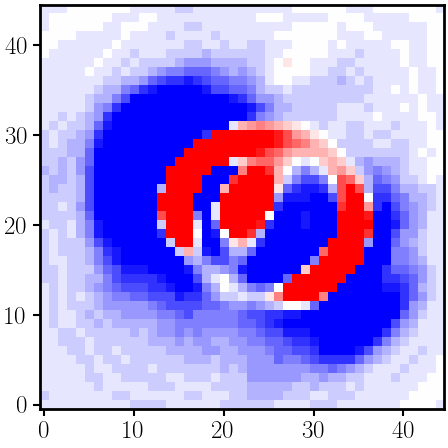

In [10]:
plt.imshow(galsim_final.array - final_image.array, cmap='bwr', vmin=-10, vmax=10)
plt.show()